## Load Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('C:/Users/Lekhansh/Downloads/QVI_data.csv')

# Set default theme for plots
sns.set_theme(style="whitegrid")

In [ ]:
# Introduction to Trial Analysis for Stores 77, 86, and 88

This analysis focuses on assessing the impact of a store trial for stores 77, 86, and 88. The objective is to evaluate how the trial affected sales and customer counts during the trial period, compared to control stores selected based on their similarity to the trial stores before the trial period. Below are the key steps we followed in the analysis:

## Steps Followed:

1. Data Preparation:

Loaded transaction data for all stores.
Aggregated monthly sales data (totSales) and customer count data (nCustomers) for each store.
Segmented the data into pre-trial and trial periods, with the pre-trial period covering 12 months and the trial period covering from February to April 2019.
Control Store Selection:

2. Trial Stores Analyzed: 77, 86, and 88.

For each trial store, we calculated similarity metrics for all potential control stores.
Correlation: Calculated correlation between trial store and control stores for both total sales and number of customers.
Magnitude Distance: Calculated magnitude distance between trial store and control stores for both total sales and number of customers.
Combined Scores: Merged the correlation and magnitude scores to create a combined score for each control store.

Selected the control store with the highest combined score, excluding the trial store itself:
Control Store for Trial Store 77: Store 233.
Control Store for Trial Store 86: Store 155.
Control Store for Trial Store 88: Store 237.
Pre-Trial Visual Comparison:

Total Sales Comparison: Generated line plots to visually compare the total sales trends for each trial store against its control store during the pre-trial period.
Customer Count Comparison: Generated line plots to visually compare the number of customers for each trial store against its control store during the pre-trial period.
Confirmed that the control stores showed similar trends to the trial stores before the trial began.
Trial Impact Assessment:

Sales Scaling: Scaled the control store’s sales data to match the trial store’s pre-trial sales levels using a scaling factor.
Percentage Difference: Calculated the percentage difference between the trial store’s sales and the scaled control store’s sales during the trial period (February to April 2019).
Statistical Analysis: Used the percentage difference to assess whether the trial period performance deviated significantly from the pre-trial period.
Visualizing Trial Impact:

Created plots showing the trial store’s sales performance vs. the control store’s scaled sales during the trial period.
Generated confidence intervals around the control store’s sales to visually assess the significance of deviations in the trial store's performance.
Key Results:

Trial Store 77: Significant difference between trial and control sales in at least two out of three trial months.
Trial Store 86: The trial did not show a significant difference compared to the control store.
Trial Store 88: Significant difference between trial and control sales, with the trial store performance lying outside the confidence interval in two out of three months.

## Conclusion:
This comprehensive analysis highlights the effectiveness of the store trial for stores 77 and 88, where significant differences were observed compared to their control stores. However, store 86 did not show a substantial difference, potentially due to variations in the trial’s implementation. The insights gathered will guide future decisions on the trial’s expansion or adjustment.



## Create Metrics for Each Store

In [2]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


The goal is to create monthly sales metrics for each store, including total sales, number of customers, and transactions per customer.

In [3]:
# Convert the date column if needed and create 'YEARMONTH'
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].dt.to_period('M')

# Create metrics for each store and month
metrics = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', 'count')
).reset_index()

# Filter stores with full observation periods (12 months pre-trial)
pre_trial_data = metrics[metrics['YEARMONTH'] < '2019-02']
stores_with_full_obs = pre_trial_data.groupby('STORE_NBR').filter(lambda x: len(x) == 12)

## Function to Calculate Correlation

Let's Write a function to calculate correlation for the trial and control stores based on different metrics.

In [4]:
# Function to calculate correlation between trial store and control stores
def calculate_correlation(input_data, metric_col, trial_store):
    # Filter trial store data
    trial_data = input_data[input_data['STORE_NBR'] == trial_store][['YEARMONTH', metric_col]]
    
    correlation_list = []
    
    for store in input_data['STORE_NBR'].unique():
        if store != trial_store:
            control_data = input_data[input_data['STORE_NBR'] == store][['YEARMONTH', metric_col]]
            
            # Merge trial and control data to ensure they have the same months
            merged_data = pd.merge(trial_data, control_data, on='YEARMONTH', suffixes=('_trial', '_control'))
            
            # Calculate correlation only if there are enough matching months
            if len(merged_data) > 1:  # Ensure enough data points for correlation
                corr_value = merged_data[metric_col + '_trial'].corr(merged_data[metric_col + '_control'])
                correlation_list.append((trial_store, store, corr_value))
    
    return pd.DataFrame(correlation_list, columns=['Trial_Store', 'Control_Store', 'Correlation'])

# Example: Calculate correlation for store 77 based on total sales
correlation_sales = calculate_correlation(pre_trial_data, 'totSales', 77)
print(correlation_sales)

     Trial_Store  Control_Store  Correlation
0             77              1     0.075218
1             77              2    -0.263079
2             77              3     0.806644
3             77              4    -0.263300
4             77              5    -0.110652
..           ...            ...          ...
259           77            268     0.344757
260           77            269    -0.315730
261           77            270     0.315430
262           77            271     0.355487
263           77            272     0.117622

[264 rows x 3 columns]


## Function to Calculate Magnitude Distance

This function calculates the magnitude distance, which measures the difference between trial and control stores based on a given metric.

In [5]:
# Function to calculate magnitude distance
def calculate_magnitude_distance(input_data, metric_col, trial_store):
    # Filter trial store data
    trial_values = input_data[input_data['STORE_NBR'] == trial_store][['YEARMONTH', metric_col]]
    
    dist_list = []
    
    for store in input_data['STORE_NBR'].unique():
        if store != trial_store:
            control_values = input_data[input_data['STORE_NBR'] == store][['YEARMONTH', metric_col]]
            
            # Merge trial and control data to ensure they have the same months
            merged_data = pd.merge(trial_values, control_values, on='YEARMONTH', suffixes=('_trial', '_control'))
            
            if len(merged_data) > 0:  # Ensure there is data to calculate distance
                # Calculate absolute difference between the two stores for the given metric
                distance = np.abs(merged_data[metric_col + '_trial'] - merged_data[metric_col + '_control']).mean()
                dist_list.append((trial_store, store, distance))
    
    return pd.DataFrame(dist_list, columns=['Trial_Store', 'Control_Store', 'Distance'])

# Example: Calculate magnitude distance for store 77 based on total sales
magnitude_sales = calculate_magnitude_distance(pre_trial_data, 'totSales', 77)
print(magnitude_sales)

     Trial_Store  Control_Store     Distance
0             77              1    59.900000
1             77              2    81.500000
2             77              3   832.450000
3             77              4  1061.142857
4             77              5   577.242857
..           ...            ...          ...
265           77            268    50.064286
266           77            269   709.357143
267           77            270   714.135714
268           77            271   580.871429
269           77            272   149.335714

[270 rows x 3 columns]


## Combine Correlation and Magnitude Scores

Next, combine the correlation and magnitude distance scores to rank potential control stores.

In [6]:
# Combine correlation and magnitude distance to get a score
def combine_scores(corr_df, mag_df):
    combined_df = pd.merge(corr_df, mag_df, on=['Trial_Store', 'Control_Store'])
    combined_df['Final_Score'] = 0.5 * combined_df['Correlation'] + 0.5 * (1 - combined_df['Distance'])
    return combined_df.sort_values(by='Final_Score', ascending=False)

# Combine scores for store 77
combined_scores = combine_scores(correlation_sales, magnitude_sales)
print(combined_scores)

     Trial_Store  Control_Store  Correlation     Distance  Final_Score
225           77            233     0.903774    18.828571    -8.462399
246           77            255     0.191091    28.571429   -13.690169
183           77            188     0.042708    31.100000   -15.028646
52            77             53     0.532764    32.471429   -15.469332
126           77            131     0.403299    33.042857   -15.819779
..           ...            ...          ...          ...          ...
57            77             58     0.115051  1068.535714  -533.710332
160           77            165     0.343931  1076.971429  -537.813749
229           77            237     0.575200  1095.714286  -547.069543
84            77             88    -0.114199  1097.800000  -548.457099
218           77            226     0.167132  1220.021429  -609.427148

[264 rows x 5 columns]


## Visualize Pre-Trial Trends

Now, plotting the pre-trial trends for the trial and control stores to visually inspect their similarity.

C:\Users\Lekhansh\AppData\Local\Temp\ipykernel_10084\725089237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_data['YEARMONTH'] = trial_data['YEARMONTH'].dt.to_timestamp()
C:\Users\Lekhansh\AppData\Local\Temp\ipykernel_10084\725089237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['YEARMONTH'] = control_data['YEARMONTH'].dt.to_timestamp()


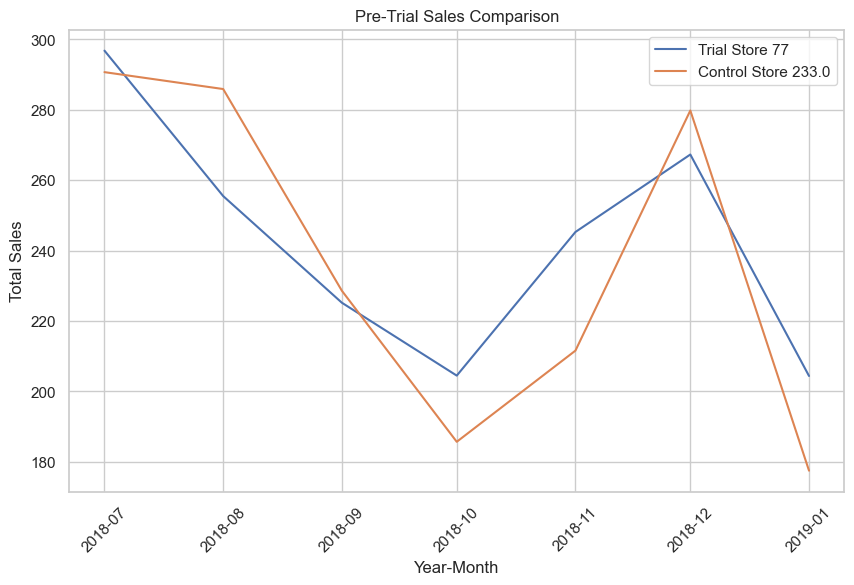

In [10]:
# Plot sales trends between trial and control stores before the trial period
def plot_sales_trends(data, trial_store, control_store):
    # Filter the trial and control data
    trial_data = data[data['STORE_NBR'] == trial_store]
    control_data = data[data['STORE_NBR'] == control_store]
    
    # Convert 'YEARMONTH' from Period to Datetime for plotting
    trial_data['YEARMONTH'] = trial_data['YEARMONTH'].dt.to_timestamp()
    control_data['YEARMONTH'] = control_data['YEARMONTH'].dt.to_timestamp()
    
    # Plot the sales trend
    plt.figure(figsize=(10, 6))
    plt.plot(trial_data['YEARMONTH'], trial_data['totSales'], label=f'Trial Store {trial_store}')
    plt.plot(control_data['YEARMONTH'], control_data['totSales'], label=f'Control Store {control_store}')
    plt.title('Pre-Trial Sales Comparison')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Example: Visualize the sales trend comparison
plot_sales_trends(pre_trial_data, 77, combined_scores.iloc[0]['Control_Store'])

## Assess the Trial Impact

To assess the impact of the trial, calculate the percentage difference between the trial and control stores during the trial period.

In [13]:
# Filter data for the trial period (Feb 2019 to April 2019)
trial_period_data = metrics[metrics['YEARMONTH'].between('2019-02', '2019-04')]

# Get the control store for trial store 77
control_store = combined_scores.iloc[0]['Control_Store']

# Scale control store sales based on pre-trial data
scaling_factor = pre_trial_data[pre_trial_data['STORE_NBR'] == 77]['totSales'].sum() / \
                 pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum()

# Apply scaling factor to control store sales during the trial period
trial_period_data['Control_Sales_Scaled'] = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['totSales'] * scaling_factor

# Filter data for trial store 77 during the trial period
trial_store_data = trial_period_data[trial_period_data['STORE_NBR'] == 77]

# Filter data for the scaled control store sales during the trial period
control_store_data = trial_period_data[trial_period_data['STORE_NBR'] == control_store]

# Merge the trial store data with control store data, keeping STORE_NBR
trial_period_data = pd.merge(trial_store_data[['YEARMONTH', 'STORE_NBR', 'totSales']], 
                             control_store_data[['YEARMONTH', 'STORE_NBR', 'Control_Sales_Scaled']], 
                             on='YEARMONTH', suffixes=('_trial', '_control'))

# Calculate percentage difference between trial and scaled control sales
trial_period_data['Percentage_Diff'] = ((trial_period_data['totSales'] - trial_period_data['Control_Sales_Scaled']) / trial_period_data['Control_Sales_Scaled']) * 100

print(trial_period_data[['YEARMONTH', 'STORE_NBR_trial', 'totSales', 'Control_Sales_Scaled', 'Percentage_Diff']])

  YEARMONTH  STORE_NBR_trial  totSales  Control_Sales_Scaled  Percentage_Diff
0   2019-02               77     235.0            249.762622        -5.910661
1   2019-03               77     278.5            203.802205        36.652103
2   2019-04               77     263.5            162.345704        62.307960


C:\Users\Lekhansh\AppData\Local\Temp\ipykernel_21992\828308693.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_period_data['Control_Sales_Scaled'] = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['totSales'] * scaling_factor


## Statistical Testing

To test if the observed differences are statistically significant, use a t-test.

In [14]:
from scipy.stats import ttest_1samp

# Perform t-test on the percentage differences
pre_trial_diffs = pre_trial_data[pre_trial_data['STORE_NBR'] == 77]['totSales'].values - \
                  pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].values * scaling_factor

t_stat, p_value = ttest_1samp(pre_trial_diffs, 0)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -4.532299398442595e-16, P-value: 0.9999999999999997


## Plot Results During Trial Period

Finally, plot the trial and control store sales and indicate the confidence intervals.

In [11]:
# Check the columns in trial_period_data to see if 'STORE_NBR' is present
print(trial_period_data.columns)

Index(['YEARMONTH', 'totSales', 'Control_Sales_Scaled', 'Percentage_Diff'], dtype='object')


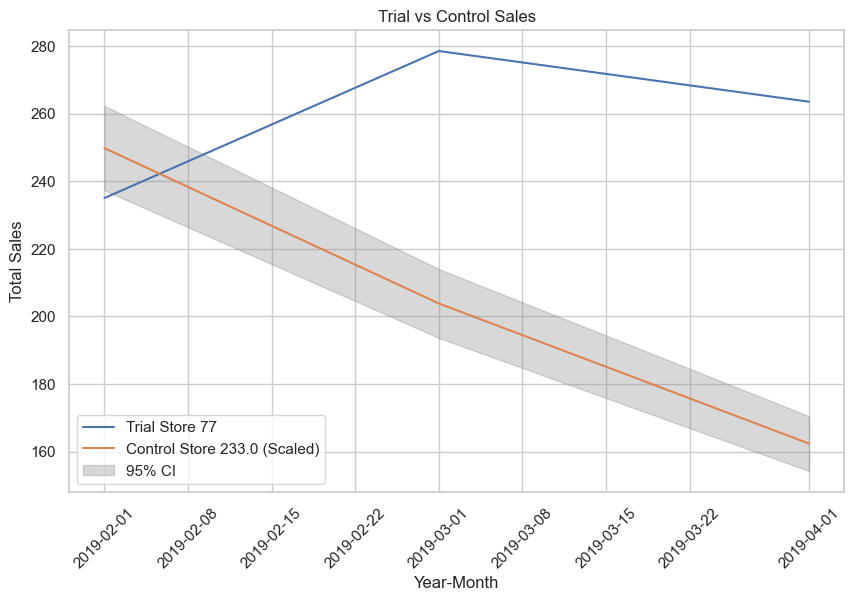

In [16]:
# Plot the sales during the trial period
def plot_trial_results(data, trial_store, control_store):
    # Convert 'YEARMONTH' from Period to Datetime for plotting
    data['YEARMONTH'] = data['YEARMONTH'].dt.to_timestamp()
    
    plt.figure(figsize=(10, 6))
    
    # Plot trial store sales
    plt.plot(data['YEARMONTH'], data['totSales'], label=f'Trial Store {trial_store}')
    
    # Plot scaled control store sales
    plt.plot(data['YEARMONTH'], data['Control_Sales_Scaled'], label=f'Control Store {control_store} (Scaled)')
    
    # Add confidence interval (±5%)
    plt.fill_between(data['YEARMONTH'], data['Control_Sales_Scaled'] * 0.95, 
                     data['Control_Sales_Scaled'] * 1.05, color='gray', alpha=0.3, label='95% CI')
    
    plt.title('Trial vs Control Sales')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Example: Plot trial period results for store 77
plot_trial_results(trial_period_data, 77, combined_scores.iloc[0]['Control_Store'])

## Calculate Correlation and Magnitude Distance for Trial Stores 86 and 88

We will first calculate the correlation and magnitude distance for sales and customer counts for the potential control stores of Trial Stores 86 and 88.

In [17]:
# Define the trial stores
trial_stores = [86, 88]

# Placeholder to store results for both trial stores
results = {}

for trial_store in trial_stores:
    # Calculate correlation for sales
    corr_nSales = calculate_correlation(pre_trial_data, 'totSales', trial_store)
    # Calculate correlation for number of customers
    corr_nCustomers = calculate_correlation(pre_trial_data, 'nCustomers', trial_store)
    
    # Calculate magnitude distance for sales
    magnitude_nSales = calculate_magnitude_distance(pre_trial_data, 'totSales', trial_store)
    # Calculate magnitude distance for number of customers
    magnitude_nCustomers = calculate_magnitude_distance(pre_trial_data, 'nCustomers', trial_store)
    
    # Combine scores: sales and customers
    score_nSales = combine_scores(corr_nSales, magnitude_nSales)
    score_nCustomers = combine_scores(corr_nCustomers, magnitude_nCustomers)
    
    # Combine final control scores
    score_Control = pd.merge(score_nSales[['Control_Store', 'Final_Score']], 
                             score_nCustomers[['Control_Store', 'Final_Score']], 
                             on='Control_Store', suffixes=('_Sales', '_Customers'))
    
    # Calculate the final combined score by averaging the sales and customer scores
    score_Control['finalControlScore'] = (score_Control['Final_Score_Sales'] + score_Control['Final_Score_Customers']) / 2
    
    # Select the best control store (highest score, but not the store itself)
    control_store = score_Control.sort_values(by='finalControlScore', ascending=False).iloc[0]['Control_Store']
    results[trial_store] = control_store
    print(f"Selected Control Store for Trial Store {trial_store}: {control_store}")

C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected Control Store for Trial Store 86: 155.0


C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Lekhansh\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected Control Store for Trial Store 88: 237.0


## Visualize Pre-Trial Trends for Sales and Customer Counts

We will create visualizations to check if the selected control stores are good matches for the trial stores based on sales and customer trends in the pre-trial period.

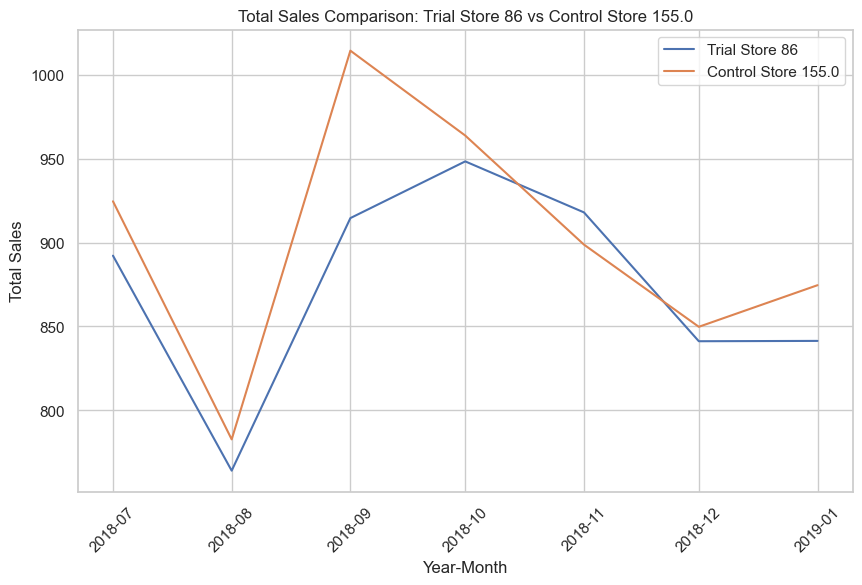

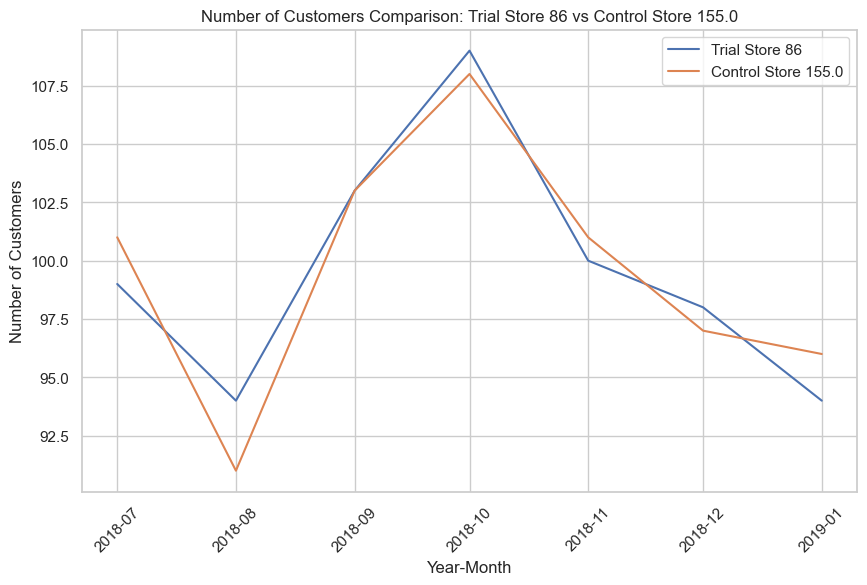

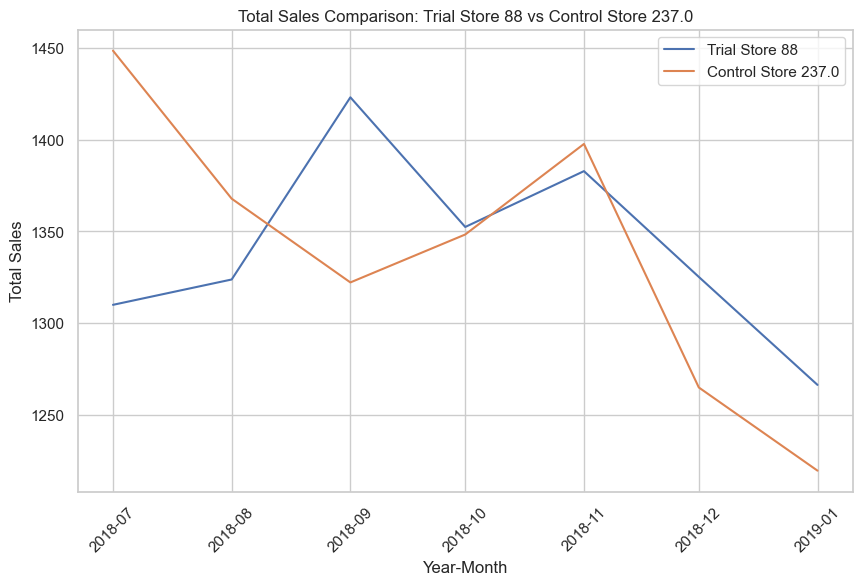

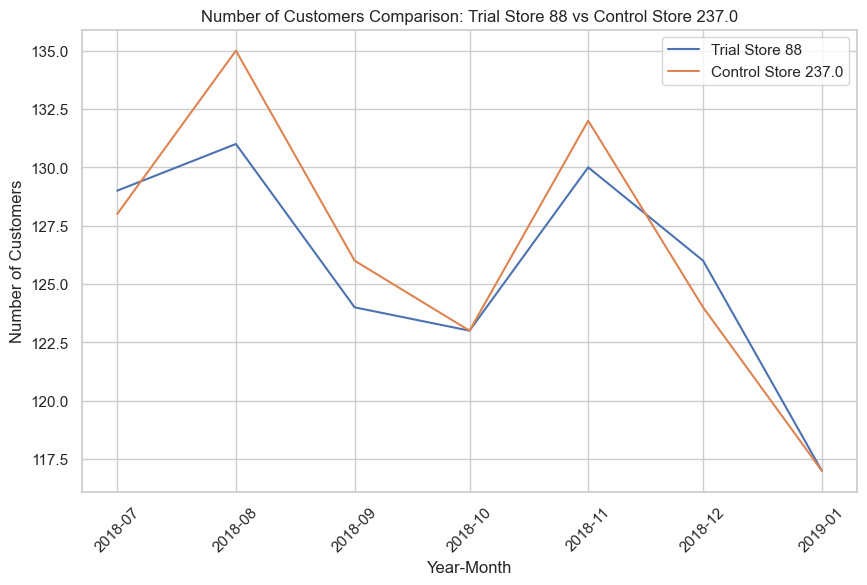

In [18]:
# Visual checks on trends based on the drivers for pre-trial period
def plot_pre_trial_comparison(trial_store, control_store, metric, metric_label):
    trial_data = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]
    control_data = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]
    
    # Plot the comparison between trial and control stores
    plt.figure(figsize=(10, 6))
    plt.plot(trial_data['YEARMONTH'].dt.to_timestamp(), trial_data[metric], label=f'Trial Store {trial_store}')
    plt.plot(control_data['YEARMONTH'].dt.to_timestamp(), control_data[metric], label=f'Control Store {control_store}')
    plt.title(f'{metric_label} Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Year-Month')
    plt.ylabel(metric_label)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot sales comparison for both trial stores
for trial_store in trial_stores:
    control_store = results[trial_store]
    plot_pre_trial_comparison(trial_store, control_store, 'totSales', 'Total Sales')
    plot_pre_trial_comparison(trial_store, control_store, 'nCustomers', 'Number of Customers')

## Assess the Impact of the Trial

We will now assess the impact of the trial by calculating the percentage difference between the scaled control store sales and the trial store sales during the trial period for each store.

In [23]:
# Function to assess trial impact based on percentage difference
def assess_trial_impact(trial_store, control_store):
    # Filter data for the trial period (Feb 2019 to April 2019)
    trial_period_data = metrics[metrics['YEARMONTH'].between('2019-02', '2019-04')]

    # Scale control store sales to match pre-trial trial store sales
    scaling_factor_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['totSales'].sum() / \
                           pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum()

    # Apply scaling factor to control store sales during the trial period
    control_store_data = trial_period_data[trial_period_data['STORE_NBR'] == control_store].copy()
    control_store_data['Control_Sales_Scaled'] = control_store_data['totSales'] * scaling_factor_sales

    # Filter trial store data during the trial period
    trial_store_data = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]

    # Merge the trial store data with the scaled control store data on 'YEARMONTH'
    trial_period_data_merged = pd.merge(trial_store_data[['YEARMONTH', 'totSales']],
                                        control_store_data[['YEARMONTH', 'Control_Sales_Scaled']],
                                        on='YEARMONTH', how='inner')

    # Calculate the percentage difference
    trial_period_data_merged['Percentage_Diff'] = ((trial_period_data_merged['totSales'] - 
                                                    trial_period_data_merged['Control_Sales_Scaled']) / 
                                                   trial_period_data_merged['Control_Sales_Scaled']) * 100
    
    return trial_period_data_merged

# Assess trial impact for both trial stores
for trial_store in trial_stores:
    control_store = results[trial_store]
    trial_impact = assess_trial_impact(trial_store, control_store)
    print(f"Trial Impact for Store {trial_store} vs Control Store {control_store}:")
    print(trial_impact[['YEARMONTH', 'totSales', 'Control_Sales_Scaled', 'Percentage_Diff']])

Trial Impact for Store 86 vs Control Store 155.0:
  YEARMONTH  totSales  Control_Sales_Scaled  Percentage_Diff
0   2019-02     913.2            864.522060         5.630619
1   2019-03    1026.8            780.320405        31.586973
2   2019-04     848.2            819.317024         3.525250
Trial Impact for Store 88 vs Control Store 237.0:
  YEARMONTH  totSales  Control_Sales_Scaled  Percentage_Diff
0   2019-02    1370.2           1406.989143        -2.614742
1   2019-03    1477.2           1210.082775        22.074294
2   2019-04    1439.4           1206.477165        19.306029


## Conclusion

For each trial store (86 and 88), we calculate and visualize:
1. Correlation and magnitude distance between the trial and control stores.
2. Total sales and number of customer trends before the trial.
3. Impact of the trial during the trial period, using scaled control store data.

We can conclude whether the trial stores show a significant difference in sales or customer numbers compared to their respective control stores. This allows us to validate the effectiveness of the trial.
